<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What still needs to be done in the project

- [x] write functions for the plots
- [x] optimize delta
- [ ] memorize the best
- [ ] benchmarking of parameters : range of lambda, range of beta, n_iter, for different models
- [ ] handle the overflow warning that appears sometimes ?
- [ ] report: properly explain our implementation, and answer the questions
- [ ] compare naive implementation with our optimization (we optimize the time mostly ? not sure)

In [1]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import copy
import time

In [2]:
class DatasetGenerator(object):
  def __init__(self, N=100):
    self.N = N
    self.x = None
    self.v = None
    self.refresh()
  
  def refresh(self):
    raise Exception("undefined")

In [3]:
class G1(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = st.uniform().rvs((self.N,))

In [4]:
class G2(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

### Uniform distribution ($\mathcal U([0,1])$)

In [5]:
g1 = G1()

Examples:

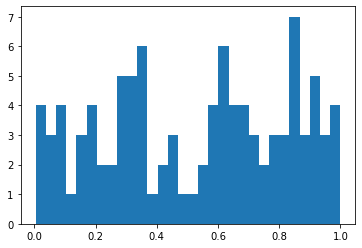

In [6]:
# Plot a histogram of the v array
plt.hist(g1.v, bins=30)
plt.show()

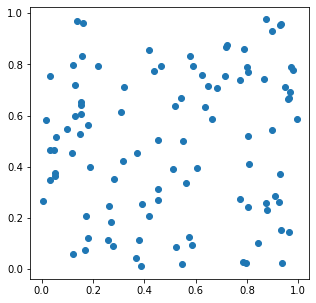

In [7]:
# plot the position of the points
plt.figure(figsize=(5,5))
plt.scatter(g1.x[:,0], g1.x[:,1])
plt.show()

You can refresh the dataset

In [8]:
g1.refresh() # generate a new dataset

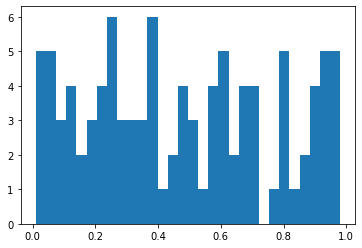

In [9]:
plt.hist(g1.v, bins=30)
plt.show()

Or for instance, you can generate 10 instances and compute the average position of all the points:

In [10]:
m = np.array([0., 0.])

for _ in range(10):
  g1.refresh() # refresh the dataset
  m  += 0.1*g1.x.mean()

print(m)

[0.50446682 0.50446682]


### Test on log-normal distribution

In [11]:
g2 = G2()

Example:

you can use g2 to generate an instance of the lognormal distribution

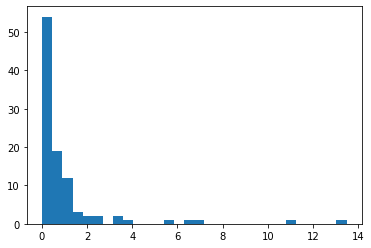

In [12]:
plt.hist(g2.v, bins=30)
plt.show()

In [13]:
g2.refresh() # to generate a new x and v

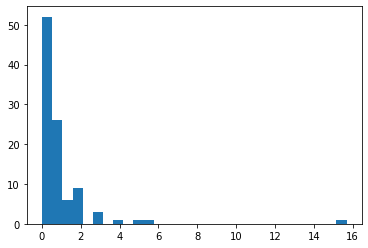

In [14]:
plt.hist(g2.v, bins=30)
plt.show()

---

# Metropolis Hastings

### **1. Implementation**

Implementation of Metropolis-Hastings algorithm to find an approximate solution of $S^*(\lambda)$

**Definition of the objective function**

**Metropolis-Hastings algorithm**

The function we want to maximize is defined on $f : \mathcal{P}(\{1,...,n\}) \rightarrow \mathbb{R}$.
To achieve this, we will minimize $g$ defined as $-f$.

<!-- f == f_lambda -->

**a) Definition of the base chain**

We choose a Symmetric Random Walk on the hypercube $C = \{0,1\}^n$. States are therefore notated as vectors x of dimension n filled with 0's and 1's.

Vocabulary: we will say that x and y are neighbours if the two vectors differ by only one digit. Example: (1,0,1,0,0) and (1,0,1,1,0) are neighbours but (1,0,1,0,0) and (1,0,1,1,1) are not.

The transition matrix is the following:
$$
\psi_{xy} = \left\{
    \begin{array}{ll}
        \frac{1}{n} & \mbox{if x and y are neighbours }  \\
        0 & \mbox{otherwise.}
    \end{array}
\right.
$$

Defined like this, it has all the necessary hypothesis to be a base chain: 
- irreducible
- $\psi_{xy} > 0$ iff $\psi_{yx} > 0$

## **TODO: prove here that we don't need aperiodicity (just like in the hw8 with the symmetric random walk on Z)!**

The idea behind taking this base chain is that a vector x of dimension n describe perfectly (meaning: without ambiguity) one set of cities S taken in $P[1,n]$.

For instance, for $n = 5$, $x = np.array([1,0,0,1,1])$ correspond to $S = \{1,4,5\}$. If the i-th digit in x is 1, it means that the i-th city is in S, if the i-th digit in x is 0, it means that the i-th city is not in S.

As a result, in the computation of the acceptance probabilities, computing g(x) will be interpreted as computing g(S) with S being the corresponding set of cities (as explained just before).

Our aim is to sample from the distribution $\pi_{\infty}(x) = \frac{\mathbb{1}_{x\ is\ a\ global\ minimum\ of\ g}}{Z_{\infty}}$.

But this is a difficult task, this is why me sample from the distribution $\pi_{\beta}$ instead $\pi_{\beta}(x) = \frac{e^{-\beta g(x)}}{Z_{\beta}}$.

But this is still difficult because of $Z_{\beta}$. This is why we will construct a Markov chain having $\pi_{\beta}$ as its stationary distribution using the Metropolis-Hastings algorithm.

**b) Definition of the acceptance probabilities**

Because if  $\psi_{xy} = \psi_{yx} = 0$ then $\frac{0}{0} = 0$ and that in any other case, $\frac{\psi_{xy}}{\psi_{yx}} = 1$, we can express the acceptance probabilities  as follows:

$$
a_{xy} = min(1, \frac{\pi_{\beta}(y)}{\pi_{\beta}(x)}) =\left\{
    \begin{array}{ll}
        min(1, e^{-\beta (g(y) - g(x))}) & \mbox{if x and y are neighbours}  \\
        0 & \mbox{otherwise.}
    \end{array}
\right.
$$


Note that here, the ${Z_{\beta}}$ cancels out in the acceptance probabilities computation (this is why we used the Metropolis-Hastings algorithm to begin with).


**c) Constructing the new chain**

The transition probabilities of the new chain is defined as follows:

$$
p_{xy} = \left\{
    \begin{array}{ll}
        \psi_{xy}a_{xy} & \mbox{if } x \ne y  \\
        1 - \sum_{v\ne x}\psi_{xv}a_{xv} & x = y
    \end{array}
\right.
$$

Because $a_{xv} = 0$ when v is not a neighbour of x, the sum can be simplified. Let us note $A_x = \{y \in C | is\_neighbour(x,y) == True\}$, then:

$$
p_{xy} = \left\{
    \begin{array}{ll}
        \psi_{xy}a_{xy} & \mbox{if } x \ne y  \\
        1 - \sum_{v \in A_x}\psi_{xv}a_{xv} & x = y
    \end{array}
\right.
$$

Which is way easier to compute because the sum has now only n terms in it!

It can be even more simplified if we write like this:

$$
p_{xy} = \left\{
    \begin{array}{ll}
        \psi_{xy}a_{xy} & \mbox{if x and y are neighbours} \\
        1 - \sum_{v \in A_x}\psi_{xv}a_{xv} & \mbox{if } x = y \\
        0 & \mbox{otherwise.}
    \end{array}
\right.
$$

Such a constructed chain will have the following property: $p_{xy}(n) \xrightarrow[n \to \infty]{} \pi_{\beta}(y)$ $\forall y$ in $C$

The idea behind the `forward()` function is to find a way to pick where to go on the next step without having to compute all the $p_{xy}$ of y in $A_x$ (which is expensive).

According to the lecture 11.2, one method would be to propose a move (propose to switch one of the digits), and then accept it with probability $a_{xy}$ after having computed $\Delta$ = g(y) - g(x). Reject it otherwise (meaning that the y will be x itself).

Note: Instead of computing g(y) and then g(x) and then the difference of the two, one can remark that:

- if x = y, $\Delta$ = 0
- if x $\ne$ y, let's note k the index of the digit that has been changed.

## **Relation to CHECK!**
<span style="color:blue">this relation holds for $x$, $y$ neighbors where the kth digit is different</span>.

$\Delta = f(\lambda, x) - f(\lambda, y) \\
= [\sum_{i \in S_x}v_i - \lambda \cdot n \cdot \max\limits_{(i,j) \in S_x^2}\pi(d(x_i,x_j)/2)^2] -  [\sum_{i \in S_y}v_i - \lambda \cdot n \cdot \max\limits_{(i,j) \in S_y^2}\pi(d(x_i,x_j)/2)^2] \\
= v_k \cdot (x[k] - y[k]) - \lambda \cdot n \cdot [\max\limits_{(i,j) \in S_x^2}\pi(d(x_i,x_j)/2)^2 - \max\limits_{(i,j) \in S_y^2}\pi(d(x_i,x_j)/2)^2] $

## **Check the following fact because the function implenting this simplification of the max didn't work:**
Instead of computing twice the max (with and without the one city changed), what we could do is to compute the max for when the city is added, and see if the k-th city intervenes in the max. If it does, then we have to calculate the second one. If it doesn't, having the k-th digit equal to 0 on the other vector will not change the maximum. Therefore the difference will be 0.

In [15]:
def vect_to_S(x):
    """
    Compute the subset S of cities corresponding to the vector encoding

    Parameters
    ----------
    x: ndarray of shape (n,)

    Returns
    -------
    S: ndarray, the subset of corresponding cities
    """
    
    return np.nonzero(x)[0]

In [16]:
def f(S, params):
    """
    Compute the objective function (that we want to maximize).
    
    Parameters
    ----------
    S: subset of P({0,..., n-1}) as an array of shape (k,) with k the size of S
    params: tuple (lambda_, n, coords, pop), where 
                lambda_ is the fixed value of the deployment cost,
                n is the fixed number of cities,
                coords is the (n,2) array containing the coordinates of each cities
                pop is the (n,) array containing the (normalized) population of each cities
                
    Returns
    -------
    f: The evaluated objective function.
    """
    lambda_, n, coords, pop = params
    
    # consider only coordinates of cities in S
    coords_S = coords[S]
    pop_S = pop[S]
    max_dist_S = np.max(sp.spatial.distance.cdist(coords_S, coords_S, 'euclidean')) if len(coords_S) > 1 else 0
    f = np.sum(pop_S) - (1/4) * lambda_ * n * np.pi * (max_dist_S)**2
    
    return f

In [17]:
def max_distance(x, coords, max_cities=False):
    """
    Compute the pairwise distance between cities represented by x
    and return the maximum distance among all of them.

    Parameters
    ----------
    x: ndarray of shape (n,)
    coords: (n, 2) array containing the coordinates of each cities
    max_cities: boolean, whether to return the city couples realising the argmax
    
    Return
    ------
    max_dist: float, the maximum distance among all pairwise distances between cities represented by x
    city_maxs: list of tuples (returned if max_cities == True), the couple of cities that intervene in the maximum distance
    """
    
    S_x = vect_to_S(x)
    if len(S_x) <= 1:
        return 0
    
    coords_S = coords[S_x]
    dists = sp.spatial.distance.cdist(coords_S, coords_S, 'euclidean')
    max_dist = np.max(dists)
    
    if not max_cities:
        return max_dist
    
    ind_maxs = np.argwhere(dists == max_dist) # indices in dist matrice of the max distance
    city_maxs = np.zeros(ind_maxs.shape[0], dtype=tuple) # change the indices to the city number
    for n, (i, j) in enumerate(ind_maxs):
        city_maxs[n] = (S_x[i], S_x[j])

    return max_dist, city_maxs

In [18]:
def Delta_computation(x, y, k, params):
    """
    Compute the difference g(y) - g(x), for x and y neighbors that differentiate only for the city k.
    
    To do this efficiently, we first handle the cases where at least one of the distances is null.
    That is if one of the vector contains 0 or 1 city.
    We then compute the maximum distance for the vector with the most cities. If the city k doesn't
    intervene in the maximum distance, then both x and y have the same maximum distance and so their
    difference is null. Otherwise, we need to compute the maximum distance of the other vector to
    compute the difference.

    Parameters
    ----------
    x: ndarray of shape (n,)
    y: ndarray of shape (n,), the proposed move
    k: int, the index of the digit different in x and y
    params: tuple (lambda_, n, coords, pop), where 
                lambda_ is the fixed value of the deployment cost,
                n is the fixed number of cities,
                coords is the (n,2) array containing the coordinates of each cities
                pop is the (n,) array containing the (normalized) population of each cities

    Returns
    -------
    Delta: the difference between g(y) and g(x)
    """
    lambda_, n, coords, pop = params
    num_ones_y = np.count_nonzero(y)
    num_ones_x = np.count_nonzero(x)
    assert num_ones_y - num_ones_x == 1 or num_ones_x - num_ones_y == 1, 'x and y should be neighbors'
    assert x[k] != y[k], 'x and y should differ at index k'
    
    #Compute first part of the delta
    Delta = pop[k] * (x[k] - y[k])
    
    
    # both vectors contain either 0 or 1 city, so both distances are null
    if num_ones_x == 0 or num_ones_y == 0:
        return Delta
        
    # one of the vector has only one city, so its distance is null : the other vector's distance has to be computed
    if num_ones_x == 1 or num_ones_y == 1:
        y_dist_null = 1 if num_ones_y == 1 else -1
        max_dist = max_distance(x, coords) if y_dist_null == 1 else max_distance(y, coords)
        Delta = Delta - (1/4) * lambda_ * n * np.pi * y_dist_null * max_dist**2
        return Delta
    
    
    # compute the maximum distance only for the vector with the most cities, i.e. where city k is added
    biggest, smallest, x_is_biggest = (x, y, 1) if num_ones_x > num_ones_y else (y, x, -1)
    max_dist_biggest, city_maxs = max_distance(biggest, coords, max_cities=True)
    
    # adding k changes the maximum distance, so max_distance of x is different of max_distance of y
    if all(k in cities for cities in city_maxs):
        max_dist_smallest = max_distance(smallest, coords)
        Delta = Delta - (1/4) * lambda_ * n * np.pi * x_is_biggest * ((max_dist_biggest)**2 - (max_dist_smallest)**2)
        return Delta

    # adding k doesn't change the maximum distance, so both max distance of x and y are equal
    return Delta

# Loic's version:
#     max_dist_x = max_distance(x, coords)
#     max_dist_y = max_distance(y, coords)
#     Delta = Delta - (1/4) * lambda_ * n * np.pi * ((max_dist_x)**2 - (max_dist_y)**2)

In [19]:
def forward(beta, x, params):
    """
    Apply one step of the Metropolis_Hastings algorithm, that is
    choose one step in the base chain, compute the associates acceptance
    probability and decide whether to accept the move in the new chain.

    Parameters
    ----------
    beta: float, the distribution parameter
    x: ndarray of shape (n,)
    params: tuple (lambda_, n, coords, pop), where 
                lambda_ is the fixed value of the deployment cost,
                n is the fixed number of cities,
                coords is the (n,2) array containing the coordinates of each cities
                pop is the (n,) array containing the (normalized) population of each cities
    
    Returns
    -------
    y: one of the neighbours of x if the move is accepted, x otherwise
    """
    lambda_, n, coords, pop = params
    
    # propose a move on the Symmetric Random Walk on hypercube of dimension n: switch one digit at random
    k = np.random.randint(0, n)
    y = x.copy()
    y[k] = (y[k] + 1)%2
    
    # compute Delta
    Delta = Delta_computation(x, y, k, params)

    # compute acceptance probability
    a_xy = 1 if Delta <= 0 else np.exp(- beta * Delta)
    
    # accept the move to y with probability a_xy and reject it with probability 1 - a_xy
    move = np.random.choice([True, False], p=[a_xy, 1 - a_xy])
    
    return y if move else x

In [57]:
def metropolis_hastings(beta, x, n_iter, params, ax_size=None, ax_obj=None):
    """
    Apply the Metropolis_Hastings algorithm for n_iter steps, starting at state x.
    If given, enters the size of the selected cities in the plot ax_size
    and the objective function evaluation in the plot ax_obj.

    Parameters
    ----------
    beta: float, the distribution parameter
    x: ndarray of shape (n,)
    n_iter: int, the number of iterations to run the Markov chain
    params: tuple (lambda_, n, coords, pop), where 
                lambda_ is the fixed value of the deployment cost,
                n is the fixed number of cities,
                coords is the (n,2) array containing the coordinates of each cities
                pop is the (n,) array containing the (normalized) population of each cities
    ax_size: the subplot axis in which to plot the evolution of the number of cities selected at each step
             if None, no plot is created
    ax_obj: the subplot axis in which to plot the evolution of the objectif function at each step
             if None, no plot is created
    
    Returns
    -------
    x: the final state of the Markov chain
    """
    N = list(range(n_iter + 1))
    if ax_size:
        nb_cities = [np.count_nonzero(x)]
    if ax_obj:
        costs = [f(vect_to_S(x), params)]
        
    max_f_visited = 0
    max_x_visited = []
    # run the Markov chain for n_iter steps
    for _ in range(n_iter):
        x = forward(beta, x, params)
        f_x = f(vect_to_S(x), params)
        if f_x>max_f_visited:
            max_f_visited = f(vect_to_S(x), params)
            max_x_visited = x
        
        if ax_size:
            nb_cities.append(np.count_nonzero(x))
        if ax_obj:
            costs.append(f(vect_to_S(x), params))
    
    f_x = f(vect_to_S(x), params)
    if f_x<max_f_visited:
            x = max_x_visited
    
    if ax_size:
        ax_size.plot(N, nb_cities, 'o')
        ax_size.set_title("Evolution of the number of cities throughout {} iterations when beta = {:.3f}".format(n_iter, beta))
        ax_size.set_xlabel("Iteration")
        ax_size.set_ylabel("Number of cities")
    if ax_obj:
        ax_obj.plot(N, costs, 'o')
        ax_obj.set_title("Evolution of the objective function throughout {} iterations when beta = {:.3f}".format(n_iter, beta))
        ax_obj.set_xlabel("Iteration")
        ax_obj.set_ylabel("Objective function f")
    
    return x

**Tuning of $\beta$**

- Start with $\beta$ small (i.e. high temperature regime):  the algorithm will then visit all the states of C quite uniformly at the beginning. After a sufficiently high number of iterations, the Metropolized chain is roughly distributed as $\pi_{\beta}$.
- Increase then $\beta$(i.e. lower the temperature) and re-run the algorithm from the state found in the previous step.
- Repeat step 2 until $\beta$ is sufficiently large, so that one can be quite sure (i.e. with prob.  1−$\epsilon$) to have reached a global minimum.

In [58]:
def simulated_annealing(betas, n_iter, params, verbose=False, plot_size=False, plot_obj=False):
    """
    Runs the Metropolis-Hastings algorithm for each beta in the list betas. For the first run, choose
    the starting state x at random, then start from the previous ending state.
    
    Parameters
    ----------
    betas: list of increasing beta (floats)
    n_iter: int, number of iteration for each beta (temperature)
    params: tuple (lambda_, n, coords, pop), where 
                lambda_ is the fixed value of the deployment cost,
                n is the fixed number of cities,
                coords is the (n,2) array containing the coordinates of each cities
                pop is the (n,) array containing the (normalized) population of each cities
    verbose: boolean, whether to print the running time of each Metropolis-Hastings algorithm
    plot_size: boolean, whether to plot the evolution of the number of cities selected for each beta
    plot_obj: boolean, whether to plot the evolution of the objectif function for each beta
    
    Returns
    -------
    S_star_approx: the approximation of the optimizing set.
    """
    lambda_, n, coords, pop = params
    
    if plot_size:
        fig_size, axs_size = plt.subplots(len(betas), figsize=(10, 30))
        fig_size.suptitle('Evolution of the number of cities (lambda={})'.format(lambda_))
    if plot_obj:
        fig_obj, axs_obj = plt.subplots(len(betas), figsize=(10,30))
        fig_obj.suptitle('Evolution of objectif function (lambda={})'.format(lambda_))
        
    # start by picking a random state on the hypercube of dimension n
    x = np.random.randint(low=0, high=2, size=n)
    
    # Riccardo: fix the starting point
    # x = np.zeros(n)
    
    # run Metropolis-Hastings algorithm for each beta
    for k, beta in enumerate(betas):
        ax_size = axs_size[k] if plot_size else None
        ax_obj = axs_obj[k] if plot_obj else None
        
        start = time.time()
        x = metropolis_hastings(beta, x, n_iter, params, ax_size, ax_obj)
        end = time.time()
        
        if verbose:
            print("[step {}/{}] Time spent on beta = {:.3f} : {:.3f} sec"
                  .format(k + 1, len(betas), beta, end - start))
    
    S_star_approx = vect_to_S(x)
    
    if plot_size:
        fig_size.tight_layout()
        figtitle = 'size_{}.pdf'.format(lambda_)
        fig_size.savefig(figtitle)
    if plot_obj:
        fig_obj.tight_layout()
        figtitle = 'obj_{}.pdf'.format(lambda_)
        fig_obj.savefig(figtitle)
    
    return S_star_approx

<span style="color:blue">write in report that we numerate the cities from 0 to n - 1 for simplicity. Doesn't change anything</span>.

**For question 2.a**: Explain how your algorithm evolves towards the solution for a given instance of G 1 . You may want
to visualize how many cities are being selected at various steps of the algorithm and plot how the
objective function evolves depending on your own algorithmic optimizations.

`plot_a` is designed to answer the first part of the question regarding visualizing how many cities are being selected at various steps of the algorithm. The goal is to use this function in order to best tune the parameters and converge as fast as possible to the solution.

`plot_a_bis` is designed to answer the second part of the question regarding visualizing how the objective function evolves at various steps of the algorithm. The goal is to use this function in order to best tune the parameters and converge as fast as possible to the solution.

## Testing the implementation

In [59]:
def testing_metropolis(G, betas, lambda_, n_iter):
    n, coords, pop = G.N, G.x, G.v
    
    print('most crowded city:', np.argwhere(pop == np.max(pop)))
    
    params = (lambda_, n, coords, pop)
    S_approx = simulated_annealing(betas, n_iter, params, verbose=True)
    
    print('S~:', S_approx)
    print('size of S~:', len(S_approx))

g1 = G1()  
lambda_ = 50
n_iter = 20000
testing_metropolis(g1, np.logspace(0, 3, 7), lambda_, n_iter)

most crowded city: [[44]]
[step 1/7] Time spent on beta = 1.000 : 2.097 sec
[step 2/7] Time spent on beta = 3.162 : 1.818 sec
[step 3/7] Time spent on beta = 10.000 : 1.692 sec
[step 4/7] Time spent on beta = 31.623 : 1.684 sec
[step 5/7] Time spent on beta = 100.000 : 1.663 sec
[step 6/7] Time spent on beta = 316.228 : 1.666 sec
[step 7/7] Time spent on beta = 1000.000 : 1.719 sec
S~: [44]
size of S~: 1


Sometimes I get the error: <ipython-input-18-b12804919efb>:29: RuntimeWarning: overflow encountered in exp
  a_xy = min(1, np.exp(-beta * Delta))... It doesn't harm the result but it's not pretty --> **TO INVESTIGATE**

In [49]:
lambda_ = 0
n_iter = 1000
testing_metropolis(g1, np.logspace(0, 3, 7), lambda_, n_iter)

most crowded city: [[51]]
[step 1/7] Time spent on beta = 1.000 : 0.153 sec
[step 2/7] Time spent on beta = 3.162 : 0.184 sec
[step 3/7] Time spent on beta = 10.000 : 0.172 sec
[step 4/7] Time spent on beta = 31.623 : 0.177 sec
[step 5/7] Time spent on beta = 100.000 : 0.187 sec
[step 6/7] Time spent on beta = 316.228 : 0.215 sec
[step 7/7] Time spent on beta = 1000.000 : 0.188 sec
S~: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
size of S~: 100


In [50]:
lambda_ = 100
n_iter = 20000
testing_metropolis(g1, np.logspace(0, 3, 7), lambda_, n_iter)

most crowded city: [[51]]
[step 1/7] Time spent on beta = 1.000 : 1.758 sec
[step 2/7] Time spent on beta = 3.162 : 1.407 sec
[step 3/7] Time spent on beta = 10.000 : 1.404 sec
[step 4/7] Time spent on beta = 31.623 : 1.426 sec
[step 5/7] Time spent on beta = 100.000 : 1.584 sec
[step 6/7] Time spent on beta = 316.228 : 1.736 sec
[step 7/7] Time spent on beta = 1000.000 : 1.653 sec
S~: [9]
size of S~: 1


## Question 2.a 

1) Plotting the number of cities at each step

In [51]:
g = G1()
n, coords, pop = g.N, g.x, g.v
lambda_ = 0.5
params = (lambda_, n, coords, pop)
betas = np.logspace(0, 3, 7)

[step 1/7] Time spent on beta = 1.000 : 3.102 sec
[step 2/7] Time spent on beta = 3.162 : 3.124 sec
[step 3/7] Time spent on beta = 10.000 : 3.231 sec
[step 4/7] Time spent on beta = 31.623 : 3.276 sec
[step 5/7] Time spent on beta = 100.000 : 3.337 sec
[step 6/7] Time spent on beta = 316.228 : 3.317 sec
[step 7/7] Time spent on beta = 1000.000 : 3.515 sec


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 13, 15, 17, 18, 20, 21, 22, 24,
       25, 26, 30, 31, 34, 36, 37, 39, 40, 41, 42, 43, 44, 46, 48, 50, 52,
       54, 55, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 79, 80, 82, 83, 85, 86, 87, 88, 90, 91, 93, 95, 96, 97, 98],
      dtype=int64)

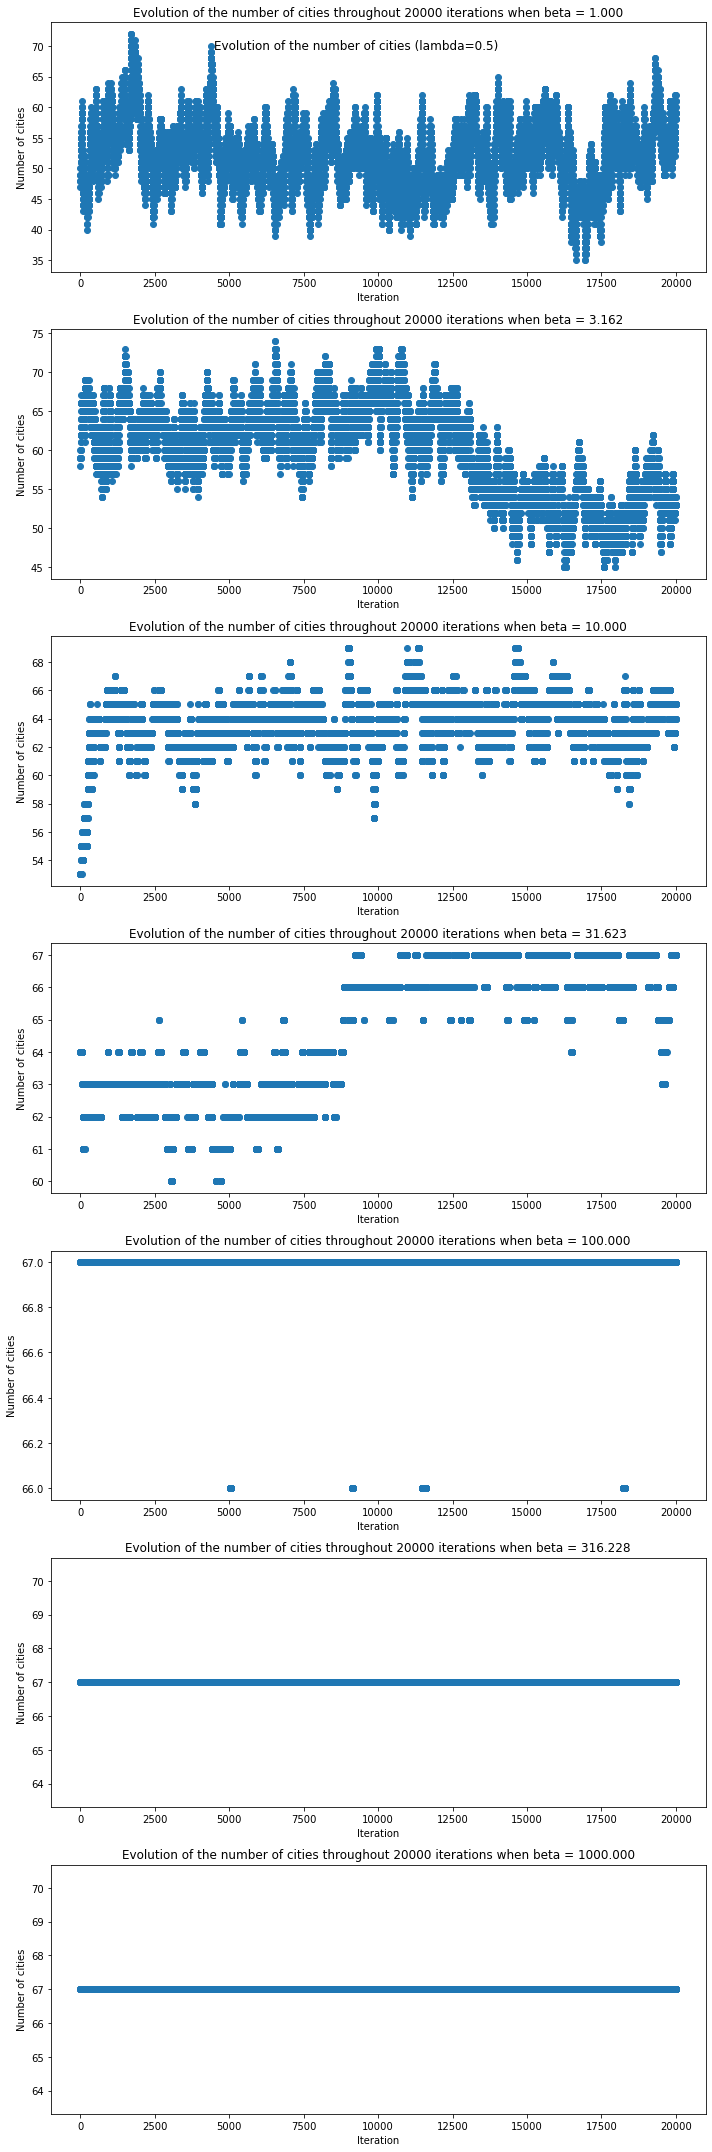

In [52]:
simulated_annealing(betas, n_iter, params, verbose=True, plot_size=True)

2) Plotting the evolution of the objective function at each step

[step 1/7] Time spent on beta = 1.000 : 4.133 sec
[step 2/7] Time spent on beta = 3.162 : 4.419 sec
[step 3/7] Time spent on beta = 10.000 : 4.752 sec
[step 4/7] Time spent on beta = 31.623 : 4.752 sec
[step 5/7] Time spent on beta = 100.000 : 4.847 sec
[step 6/7] Time spent on beta = 316.228 : 4.837 sec
[step 7/7] Time spent on beta = 1000.000 : 4.867 sec


array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 20, 21,
       22, 23, 26, 27, 28, 29, 30, 31, 34, 35, 36, 38, 39, 40, 41, 42, 43,
       46, 48, 49, 50, 51, 52, 53, 56, 57, 58, 60, 61, 63, 64, 65, 66, 70,
       71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 94, 96, 97, 98, 99], dtype=int64)

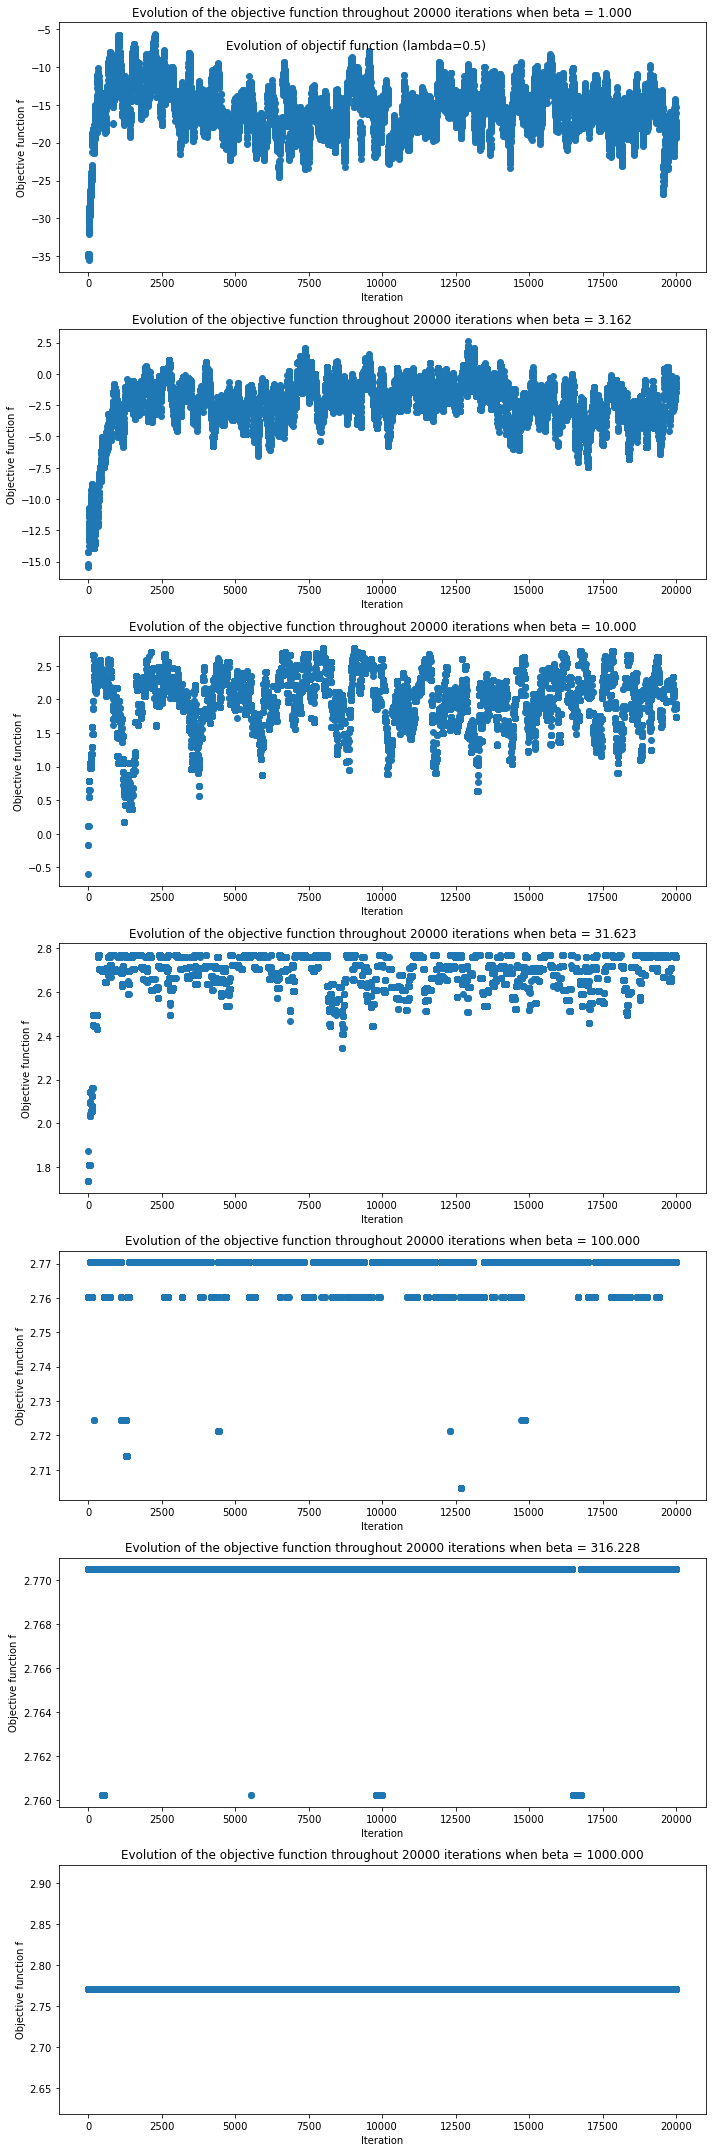

In [27]:
simulated_annealing(betas, n_iter, params, verbose=True, plot_obj=True)

<span style="color:blue">Need to analyse this plots, explain how they evolve, how fast they converge, that we see that f is indeed maximize, the result tends to a bigger objective function</span>.

**For question 2.b.**: Explain how E G 1 [|S* (λ)|] and E G 1 [f (λ, S*(λ))] evolve with respect to λ using a plot (the average
being taken over multiple instances of G 1 ).

With the function `best_S()`, we compute approximations of $S^*$ for different instances, for a fixed lambda.

Then we take the respective expectation (`expectation_card_S` or `expectation_f_S`) for that lambda. Finally, we repeat this for every lambda in the `plot_b` and `plot_b_bis` functions (for `expectation_card_S` and `expectation_f_S` respectively) to get that expectation for every lambda in [0,1]. These last two functions will plot the result. It can take a bit of time to compute (as it basically solving the problem on multiple lambas and multiple times to get an expectation.

**Note**: Can take a few minutes to compute

In [28]:
def best_S(G, betas, lambda_, n_iter, nb_instances, verbose=False):
    """
    Compute approximation of S* for nb_instances different instances of G.
    The approximation follows the simulated annealing algorithm.
    
    Returns
    -------
    S_approxs: list of S approximated by solving many times the problem over multiple instances of G at lambda_ fixed
    list_params: list of parameters used
    """  
    S_approxs = []
    list_params = []
    
    for k in range(nb_instances):
        g = G()
        n, coords, pop = g1.N, g1.x, g1.v
        params = (lambda_, n, coords, pop)
        x = np.random.randint(0, 2, n)
        
        # run the Metropolis-Hastings algorithm for each beta
        for beta in betas:
            x = metropolis_hastings(beta, x, n_iter, params)
        
        S_approxs.append(vect_to_S(x))
        list_params.append(params)
        
        if verbose:
            print("[lambda={} : {}/{}]".format(lambda_, k + 1, nb_instances))
        
    return S_approxs, list_params

In [29]:
def avg_size_S(G, betas, lambda_, n_iter, nb_instances, verbose=False):
    """
    Compute the average size of selected cities for the (approximated) best set S.
    """
    S_approxs, _ = best_S(G, betas, lambda_, n_iter, nb_instances, verbose)
    return np.sum(list(map(len, S_approxs))) / nb_instances

In [30]:
def avg_obj_S(G, betas, lambda_, n_iter, nb_instances, verbose=False):
    """
    Compute the average value of the objective function for the (approximated) best set S.
    """
    S_approxs, list_params = best_S(G, betas, lambda_, n_iter, nb_instances, verbose)
    return np.sum(list(map(f, S_approxs, list_params))) / nb_instances

In [31]:
def plot_avg_size(G, lambdas, betas, n_iter, nb_instances, verbose=False):
    E = [avg_size_S(G, betas, lambda_, n_iter, nb_instances, verbose) for lambda_ in lambdas]
    
    plt.plot(lambdas, E, 'o')
    plt.title("Expectation of the number of cities over multiple instances of G1 for different lambdas")
    plt.xlabel("Lambda")
    plt.ylabel("Expectation")
    plt.savefig('avg_size_{}to{}.pdf'.format(lambdas[0], lambdas[-1]))

In [32]:
def plot_avg_obj(G, lambdas, betas, n_iter, nb_instances, verbose=False):
    E = [avg_obj_S(G, betas, lambda_, n_iter, nb_instances, verbose) for lambda_ in lambdas]
    
    plt.plot(lambdas, E, 'o')
    plt.title("Expectation of the objective function over multiple instances of G1 for different lambdas")
    plt.xlabel("Lambda")
    plt.ylabel("Expectation")
    plt.savefig('avg_obj_{}to{}.pdf'.format(lambdas[0], lambdas[-1]))

## **Question 2.b**

1) Plotting E(|S*(lambda)|) for lambda in range [0.1, 10]

In [33]:
lambdas = np.linspace(-1, 1, 5)

[lambda=-1.0 : 1/5]
[lambda=-1.0 : 2/5]
[lambda=-1.0 : 3/5]
[lambda=-1.0 : 4/5]
[lambda=-1.0 : 5/5]
[lambda=-0.5 : 1/5]
[lambda=-0.5 : 2/5]
[lambda=-0.5 : 3/5]
[lambda=-0.5 : 4/5]
[lambda=-0.5 : 5/5]
[lambda=0.0 : 1/5]
[lambda=0.0 : 2/5]
[lambda=0.0 : 3/5]
[lambda=0.0 : 4/5]
[lambda=0.0 : 5/5]
[lambda=0.5 : 1/5]
[lambda=0.5 : 2/5]
[lambda=0.5 : 3/5]
[lambda=0.5 : 4/5]
[lambda=0.5 : 5/5]
[lambda=1.0 : 1/5]
[lambda=1.0 : 2/5]
[lambda=1.0 : 3/5]
[lambda=1.0 : 4/5]
[lambda=1.0 : 5/5]


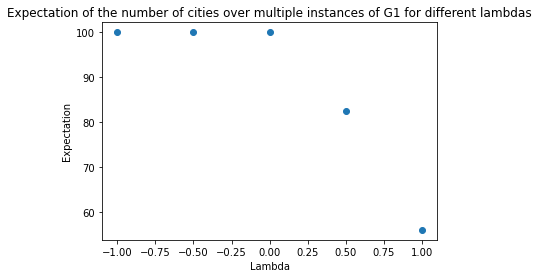

In [34]:
plot_avg_size(G1, lambdas, betas, 2000, 5, verbose=True)

[lambda=-1.0 : 1/5]
[lambda=-1.0 : 2/5]
[lambda=-1.0 : 3/5]
[lambda=-1.0 : 4/5]
[lambda=-1.0 : 5/5]
[lambda=-0.5 : 1/5]
[lambda=-0.5 : 2/5]
[lambda=-0.5 : 3/5]
[lambda=-0.5 : 4/5]
[lambda=-0.5 : 5/5]
[lambda=0.0 : 1/5]
[lambda=0.0 : 2/5]
[lambda=0.0 : 3/5]
[lambda=0.0 : 4/5]
[lambda=0.0 : 5/5]
[lambda=0.5 : 1/5]
[lambda=0.5 : 2/5]
[lambda=0.5 : 3/5]
[lambda=0.5 : 4/5]
[lambda=0.5 : 5/5]
[lambda=1.0 : 1/5]
[lambda=1.0 : 2/5]
[lambda=1.0 : 3/5]
[lambda=1.0 : 4/5]
[lambda=1.0 : 5/5]


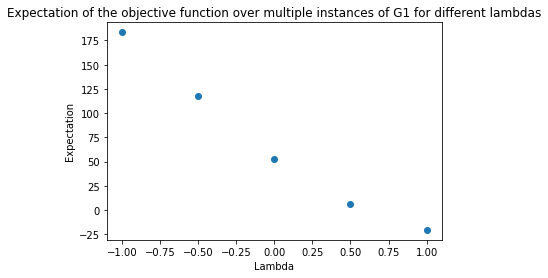

In [35]:
plot_avg_obj(G1, lambdas, betas, 2000, 5, verbose=True)

## Same questions for model G2

In [36]:
g = G2()
n, coords, pop = g.N, g.x, g.v
lambda_ = 100
params = (lambda_, n, coords, pop)
betas = np.logspace(0, 3, 7)

[step 1/7] Time spent on beta = 1.000 : 1.784 sec
[step 2/7] Time spent on beta = 3.162 : 1.446 sec
[step 3/7] Time spent on beta = 10.000 : 1.473 sec
[step 4/7] Time spent on beta = 31.623 : 1.475 sec
[step 5/7] Time spent on beta = 100.000 : 1.472 sec
[step 6/7] Time spent on beta = 316.228 : 1.544 sec
[step 7/7] Time spent on beta = 1000.000 : 1.449 sec


array([88], dtype=int64)

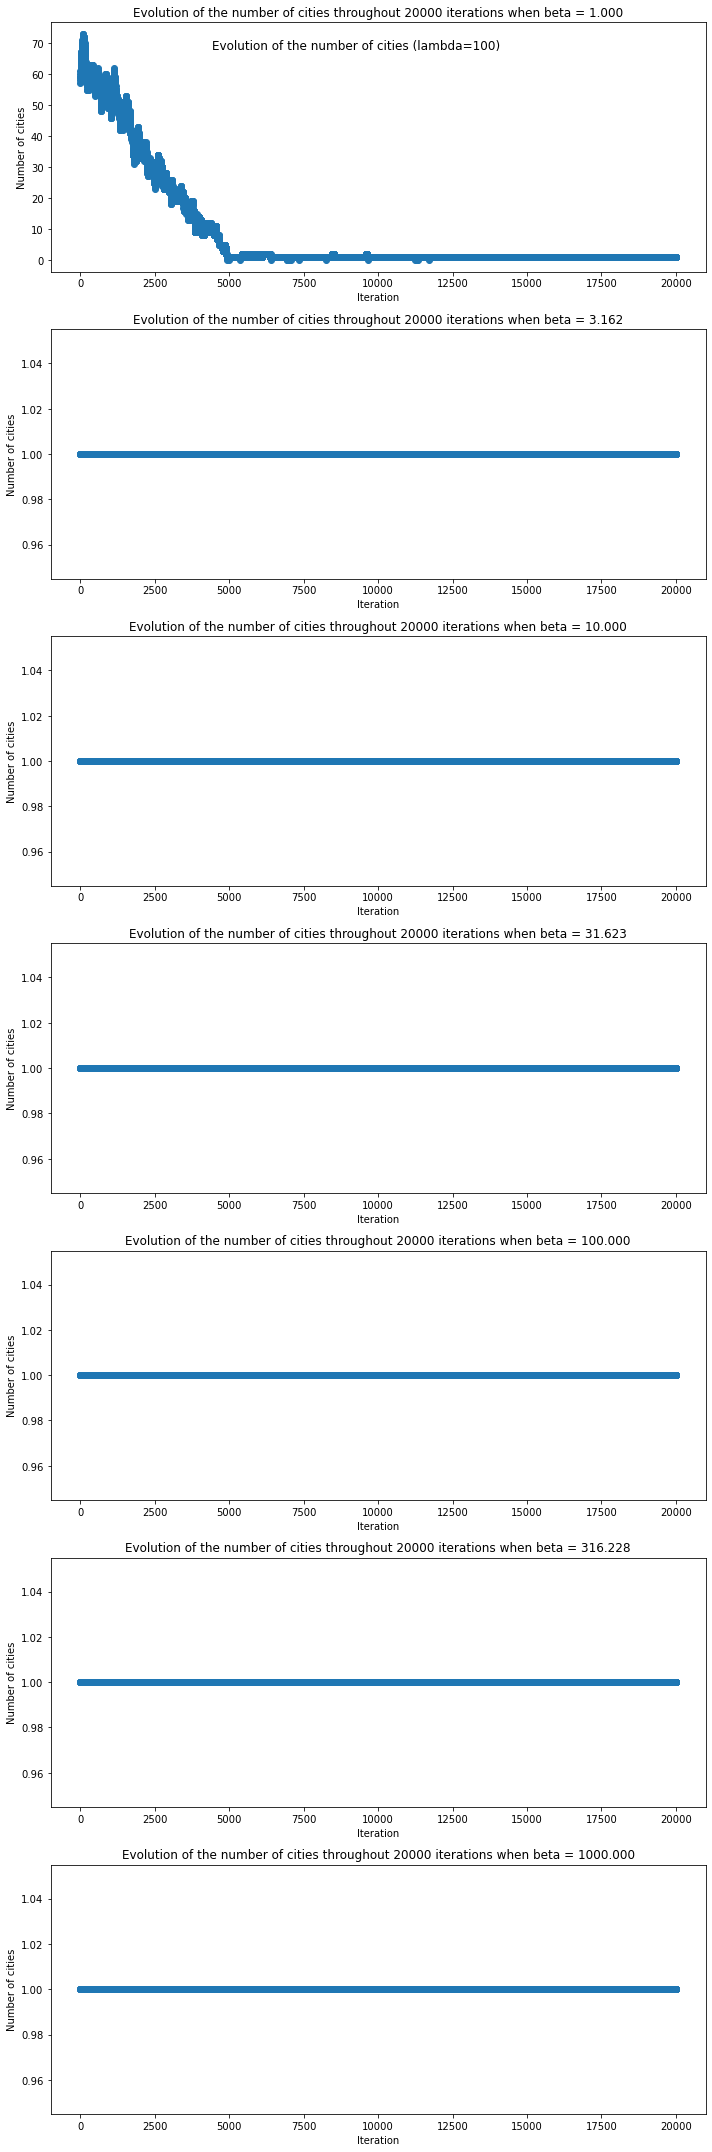

In [37]:
simulated_annealing(betas, n_iter, params, verbose=True, plot_size=True)

[step 1/7] Time spent on beta = 1.000 : 2.196 sec
[step 2/7] Time spent on beta = 3.162 : 1.802 sec
[step 3/7] Time spent on beta = 10.000 : 1.798 sec
[step 4/7] Time spent on beta = 31.623 : 1.860 sec
[step 5/7] Time spent on beta = 100.000 : 1.776 sec
[step 6/7] Time spent on beta = 316.228 : 1.881 sec
[step 7/7] Time spent on beta = 1000.000 : 1.986 sec


array([59], dtype=int64)

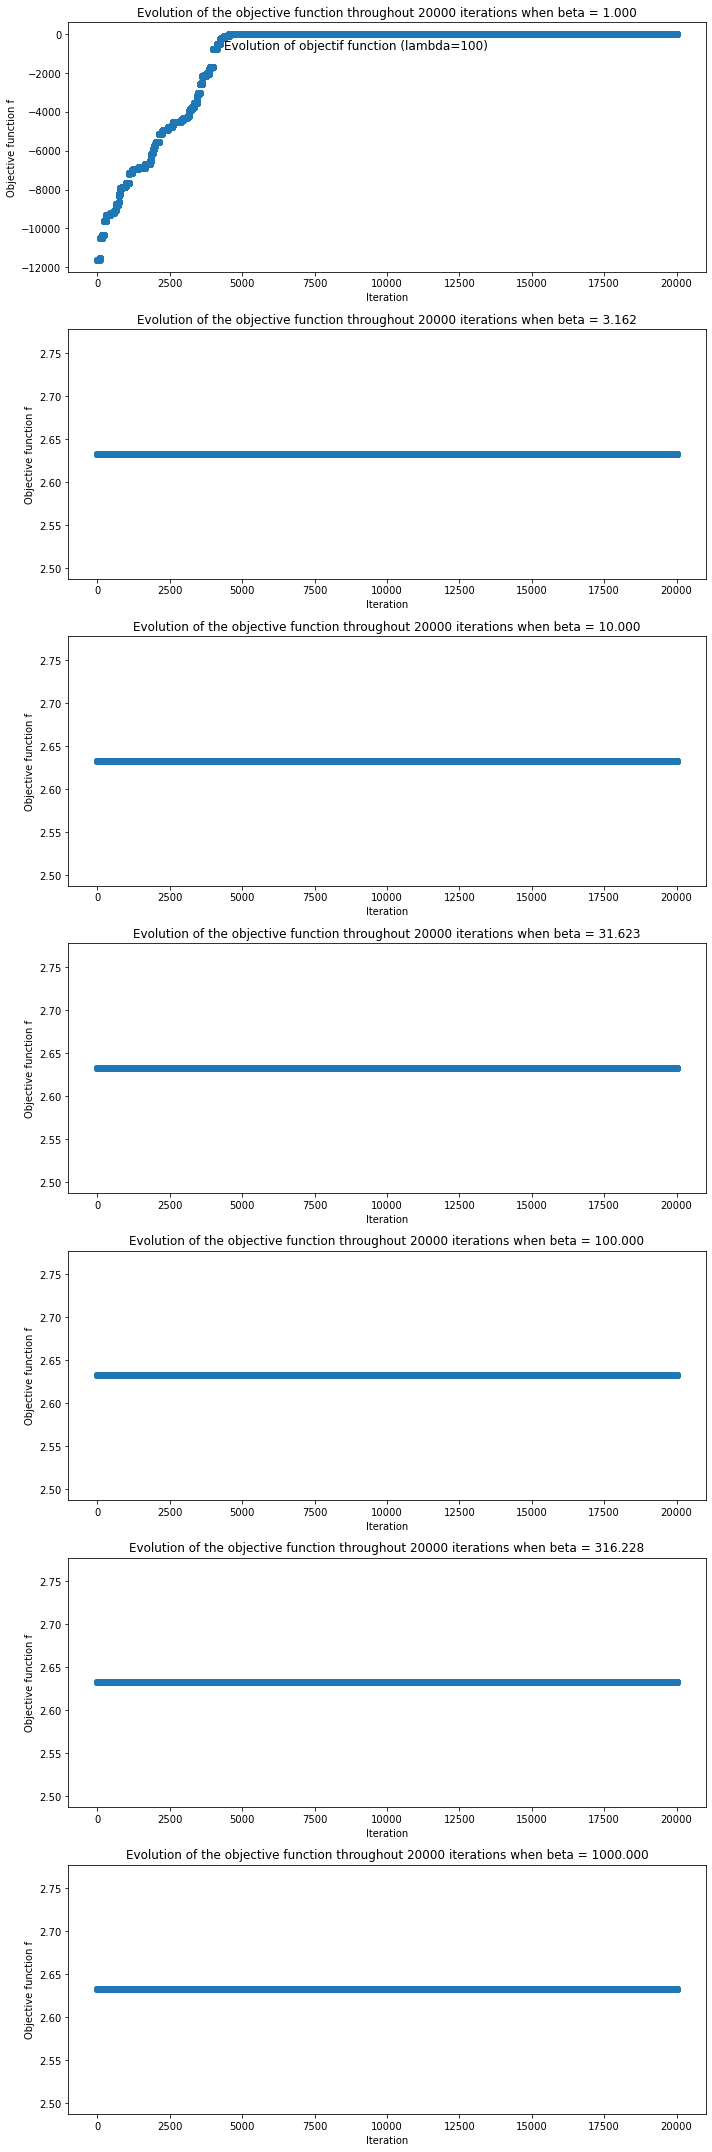

In [38]:
simulated_annealing(betas, n_iter, params, verbose=True, plot_obj=True)

wow, converges quickly here ...

[lambda=0.0 : 1/5]
[lambda=0.0 : 2/5]
[lambda=0.0 : 3/5]
[lambda=0.0 : 4/5]
[lambda=0.0 : 5/5]
[lambda=0.5 : 1/5]
[lambda=0.5 : 2/5]
[lambda=0.5 : 3/5]
[lambda=0.5 : 4/5]
[lambda=0.5 : 5/5]
[lambda=1.0 : 1/5]
[lambda=1.0 : 2/5]
[lambda=1.0 : 3/5]
[lambda=1.0 : 4/5]
[lambda=1.0 : 5/5]
[lambda=1.5 : 1/5]
[lambda=1.5 : 2/5]
[lambda=1.5 : 3/5]
[lambda=1.5 : 4/5]
[lambda=1.5 : 5/5]
[lambda=2.0 : 1/5]
[lambda=2.0 : 2/5]
[lambda=2.0 : 3/5]
[lambda=2.0 : 4/5]
[lambda=2.0 : 5/5]


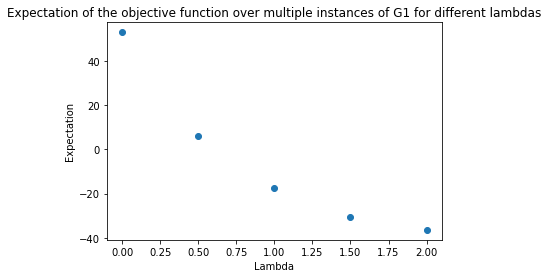

In [39]:
lambdas = np.linspace(0, 2, 5)

plot_avg_obj(G2, lambdas, betas, 2000, 5, verbose=True)

[lambda=0.0 : 1/5]
[lambda=0.0 : 2/5]
[lambda=0.0 : 3/5]
[lambda=0.0 : 4/5]
[lambda=0.0 : 5/5]
[lambda=0.5 : 1/5]
[lambda=0.5 : 2/5]
[lambda=0.5 : 3/5]
[lambda=0.5 : 4/5]
[lambda=0.5 : 5/5]
[lambda=1.0 : 1/5]
[lambda=1.0 : 2/5]
[lambda=1.0 : 3/5]
[lambda=1.0 : 4/5]
[lambda=1.0 : 5/5]
[lambda=1.5 : 1/5]
[lambda=1.5 : 2/5]
[lambda=1.5 : 3/5]
[lambda=1.5 : 4/5]
[lambda=1.5 : 5/5]
[lambda=2.0 : 1/5]
[lambda=2.0 : 2/5]
[lambda=2.0 : 3/5]
[lambda=2.0 : 4/5]
[lambda=2.0 : 5/5]


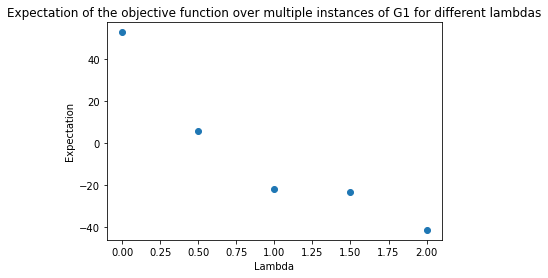

In [40]:
lambdas = np.linspace(0, 2, 5)
plot_avg_obj(G2, lambdas, betas, 2000, 5, verbose=True)

## Same questions with other models (so that we can compare etc), for example by taking avergae position of each points